# Developing an AI application

Going forward, AI algorithms will be incorporated into more and more everyday applications. For example, you might want to include an image classifier in a smart phone app. To do this, you'd use a deep learning model trained on hundreds of thousands of images as part of the overall application architecture. A large part of software development in the future will be using these types of models as common parts of applications. 

In this project, you'll train an image classifier to recognize different species of flowers. You can imagine using something like this in a phone app that tells you the name of the flower your camera is looking at. In practice you'd train this classifier, then export it for use in your application. We'll be using [this dataset](http://www.robots.ox.ac.uk/~vgg/data/flowers/102/index.html) of 102 flower categories, you can see a few examples below. 

<img src='assets/Flowers.png' width=500px>

The project is broken down into multiple steps:

* Load and preprocess the image dataset
* Train the image classifier on your dataset
* Use the trained classifier to predict image content

We'll lead you through each part which you'll implement in Python.

When you've completed this project, you'll have an application that can be trained on any set of labeled images. Here your network will be learning about flowers and end up as a command line application. But, what you do with your new skills depends on your imagination and effort in building a dataset. For example, imagine an app where you take a picture of a car, it tells you what the make and model is, then looks up information about it. Go build your own dataset and make something new.

First up is importing the packages you'll need. It's good practice to keep all the imports at the beginning of your code. As you work through this notebook and find you need to import a package, make sure to add the import up here.

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# Imports here
import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models
from collections import OrderedDict
import time
from PIL import Image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb

## Load the data

Here you'll use `torchvision` to load the data ([documentation](http://pytorch.org/docs/0.3.0/torchvision/index.html)). The data should be included alongside this notebook, otherwise you can [download it here](https://s3.amazonaws.com/content.udacity-data.com/nd089/flower_data.tar.gz). The dataset is split into three parts, training, validation, and testing. For the training, you'll want to apply transformations such as random scaling, cropping, and flipping. This will help the network generalize leading to better performance. You'll also need to make sure the input data is resized to 224x224 pixels as required by the pre-trained networks.

The validation and testing sets are used to measure the model's performance on data it hasn't seen yet. For this you don't want any scaling or rotation transformations, but you'll need to resize then crop the images to the appropriate size.

The pre-trained networks you'll use were trained on the ImageNet dataset where each color channel was normalized separately. For all three sets you'll need to normalize the means and standard deviations of the images to what the network expects. For the means, it's `[0.485, 0.456, 0.406]` and for the standard deviations `[0.229, 0.224, 0.225]`, calculated from the ImageNet images.  These values will shift each color channel to be centered at 0 and range from -1 to 1.
 

In [2]:
data_dir = 'flowers'
train_dir = data_dir + '/train'
valid_dir = data_dir + '/valid'
test_dir = data_dir + '/test'

In [3]:
# TODO: Define your transforms for the training, validation, and testing sets
data_transforms = {'train': transforms.Compose([
                                                transforms.RandomRotation(30),
                                                transforms.RandomResizedCrop(224),
                                                transforms.RandomHorizontalFlip(),
                                                transforms.ToTensor(),
                                                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])]),
                  'test' : transforms.Compose([transforms.Resize(256),
                                               transforms.CenterCrop(224),
                                               transforms.ToTensor(),
                                               transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])]),
                  'validation' : transforms.Compose([transforms.Resize(256),
                                                     transforms.CenterCrop(224),
                                                     transforms.ToTensor(),
                                                     transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])}

# TODO: Load the datasets with ImageFolder
image_datasets = {'train' : datasets.ImageFolder(train_dir, transform=data_transforms['train']),
                 'test' : datasets.ImageFolder(test_dir, transform=data_transforms['test']),
                 'validation' : datasets.ImageFolder(valid_dir, transform=data_transforms['validation'])}

# TODO: Using the image datasets and the trainforms, define the dataloaders
dataloaders = {'train' : torch.utils.data.DataLoader(image_datasets['train'], batch_size=130, shuffle=True),
              'test' : torch.utils.data.DataLoader(image_datasets['test'], batch_size=130),
              'validation' : torch.utils.data.DataLoader(image_datasets['validation'], batch_size=130)}

### Label mapping

You'll also need to load in a mapping from category label to category name. You can find this in the file `cat_to_name.json`. It's a JSON object which you can read in with the [`json` module](https://docs.python.org/2/library/json.html). This will give you a dictionary mapping the integer encoded categories to the actual names of the flowers.

In [4]:
import json

with open('cat_to_name.json', 'r') as f:
    cat_to_name = json.load(f)

# Building and training the classifier

Now that the data is ready, it's time to build and train the classifier. As usual, you should use one of the pretrained models from `torchvision.models` to get the image features. Build and train a new feed-forward classifier using those features.

We're going to leave this part up to you. If you want to talk through it with someone, chat with your fellow students! You can also ask questions on the forums or join the instructors in office hours.

Refer to [the rubric](https://review.udacity.com/#!/rubrics/1663/view) for guidance on successfully completing this section. Things you'll need to do:

* Load a [pre-trained network](http://pytorch.org/docs/master/torchvision/models.html) (If you need a starting point, the VGG networks work great and are straightforward to use)
* Define a new, untrained feed-forward network as a classifier, using ReLU activations and dropout
* Train the classifier layers using backpropagation using the pre-trained network to get the features
* Track the loss and accuracy on the validation set to determine the best hyperparameters

We've left a cell open for you below, but use as many as you need. Our advice is to break the problem up into smaller parts you can run separately. Check that each part is doing what you expect, then move on to the next. You'll likely find that as you work through each part, you'll need to go back and modify your previous code. This is totally normal!

When training make sure you're updating only the weights of the feed-forward network. You should be able to get the validation accuracy above 70% if you build everything right. Make sure to try different hyperparameters (learning rate, units in the classifier, epochs, etc) to find the best model. Save those hyperparameters to use as default values in the next part of the project.

In [5]:
# TODO: Build and train your network

model = models.vgg16(pretrained=True)
model

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.torch/models/vgg16-397923af.pth
100%|██████████| 553433881/553433881 [00:25<00:00, 21429315.16it/s]


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (17): Conv2d

In [6]:
for param in model.parameters():
    param.requires_grad = False

classifier = nn.Sequential(OrderedDict([
    ('fc1', nn.Linear(25088, 2509)),
    ('relu1', nn.ReLU()),
    ('dropout1', nn.Dropout(p = 0.5)),
    ('fc2', nn.Linear(2509, 102)),
    ('output', nn.LogSoftmax(dim=1))
    ]))

'''
TEST 1 73% accuracy with .0001 learnrate & 3 epochs
classifier = nn.Sequential(OrderedDict([
    ('fc1', nn.Linear(25088, 5000)),
    ('relu1', nn.ReLU()),
    ('dropout1', nn.Dropout(p = 0.5)),
    ('fc2', nn.Linear(5000, 1250)),
    ('relu2', nn.ReLU()),
    ('dropout2', nn.Dropout(p = 0.5)),
    ('fc3', nn.Linear(1250, 102)),
    ('output', nn.LogSoftmax(dim=1))
    ]))
'''

'''
Test 2 83% accuracty with .0001 learnrate, 3 epochs, & bin size 130
classifier = nn.Sequential(OrderedDict([
    ('fc1', nn.Linear(25088, 2509)),
    ('relu1', nn.ReLU()),
    ('dropout1', nn.Dropout(p = 0.5)),
    ('fc2', nn.Linear(2509, 102)),
    ('output', nn.LogSoftmax(dim=1))
    ]))
'''
model.classifier = classifier

In [7]:
learnrate = 0.0001
epochs = 3
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.classifier.parameters(), lr=learnrate)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [8]:
# Function for training 
def train_network(model, train_data, validation_data, epochs, print_every, criterion, optimizer, device):
    '''
    Builds a network using feedforward and backpropagation with the VGG16 pretrained model.
    
    Arguments:
        model: The VGG16 pretrained model
        train_data: The training data set used to train the model
        validation_data: The validation data used to test for overfitting while training
        epochs: The amount of epochs the model will run.
        print_every: When function will print loss.
        criterion = The criterion input used for the model.
        optimizer: The optimizer input used for the model.
        device: The type of device to run the model with. Either CPU or CUDA.
    
    Outputs:
        Trained neural network that has been tested with validation data to prevent overfitting. 
    '''
    steps = 0
    # Switch model to cuda to increate spead of training
    model.to('cuda')
    # Loop through all epochs
    print('Training starting...')
    for e in range(epochs):
        running_loss = 0
        for ii, (inputs, labels) in enumerate(train_data):
            steps += 1

            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            
            # Forward pass through your model
            outputs = model.forward(inputs)

            # Find loss value
            loss = criterion(outputs, labels)
            # Backward pass though your model
            loss.backward()

            optimizer.step()
            # Add to the running loss to keep track of
            running_loss += loss.item()
            
            # Check the current step of epoch and print Epoch, Training Loss, Validation Loss and Test Accuracy.
            if steps % print_every == 0:
                # Turn on evalution mode to test for overfitting.
                model.eval()
                #Turn off gradients for validation testing.
                with torch.no_grad():
                    test_loss, accuracy = validation(model, validation_data, criterion)
                    
                print("Epoch: {}/{}... ".format(e+1, epochs),
                      "Training Loss: {:.4f}.. ".format(running_loss/print_every),
                      "Validation Loss: {:.4f}.. ".format(test_loss/len(validation_data)),
                      "Test Accuracy: {:.4f}".format(accuracy/len(validation_data)))
                # Set running loss back to 0
                running_loss = 0
                # Return your model to training model.
                model.train()
    print('Training complete')
    
def validation(model, validation_data, criterion):
    '''
    Validates the the accuracy of the neural network using validation data.
    
    Arguments:
        model: The VGG16 pretrained model
        validation_data: The validation data used to test for overfitting while training
        criterion = The criterion input used for the model.
    
    Outputs:
        The accuracy of the neural network represented in test_lost and accuracy.
    '''
    test_loss = 0
    accuracy = 0
    for inputs, labels in validation_data:
        
        inputs, labels = inputs.to(device), labels.to(device)

        output = model.forward(inputs)
        test_loss += criterion(output, labels).item()
        
        ps = torch.exp(output)
        equality = (labels.data == ps.max(dim=1)[1])
        accuracy += equality.type(torch.FloatTensor).mean()
        
    return test_loss, accuracy
                
train_network(model, dataloaders['train'], dataloaders['validation'], epochs, 20, criterion, optimizer, device)

Training starting...
Epoch: 1/3...  Training Loss: 3.9710..  Validation Loss: 2.7516..  Test Accuracy: 0.4305
Epoch: 1/3...  Training Loss: 2.6507..  Validation Loss: 1.5958..  Test Accuracy: 0.6527
Epoch: 2/3...  Training Loss: 0.7423..  Validation Loss: 1.0820..  Test Accuracy: 0.7640
Epoch: 2/3...  Training Loss: 1.4932..  Validation Loss: 0.8419..  Test Accuracy: 0.8263
Epoch: 2/3...  Training Loss: 1.3353..  Validation Loss: 0.6944..  Test Accuracy: 0.8563
Epoch: 3/3...  Training Loss: 0.9836..  Validation Loss: 0.5718..  Test Accuracy: 0.8585
Epoch: 3/3...  Training Loss: 1.0239..  Validation Loss: 0.4999..  Test Accuracy: 0.8916
Training complete


## Testing your network

It's good practice to test your trained network on test data, images the network has never seen either in training or validation. This will give you a good estimate for the model's performance on completely new images. Run the test images through the network and measure the accuracy, the same way you did validation. You should be able to reach around 70% accuracy on the test set if the model has been trained well.

In [9]:
# TODO: Do validation on the test set
def test_network(test_data, device):
    '''
    Tests the accuracy of the trained neural network using the test data
    
    Arguments:
        test_data: Tests data used to test neural network. 
    Outputs:
        The accuracy of the network displayed via print.
    '''
    correct = 0
    total = 0
    print('Testing starting...')
    with torch.no_grad():
        for data in test_data:
            images, labels = data
            # Set images and to use cuda
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
    print('Accuracy of the network on the 10000 test images: %d %%' % (100 * correct / total))
    print('Testing complete.')
    
test_network(dataloaders['test'], device)

Testing starting...
Accuracy of the network on the 10000 test images: 82 %
Testing complete.


## Save the checkpoint

Now that your network is trained, save the model so you can load it later for making predictions. You probably want to save other things such as the mapping of classes to indices which you get from one of the image datasets: `image_datasets['train'].class_to_idx`. You can attach this to the model as an attribute which makes inference easier later on.

```model.class_to_idx = image_datasets['train'].class_to_idx```

Remember that you'll want to completely rebuild the model later so you can use it for inference. Make sure to include any information you need in the checkpoint. If you want to load the model and keep training, you'll want to save the number of epochs as well as the optimizer state, `optimizer.state_dict`. You'll likely want to use this trained model in the next part of the project, so best to save it now.

In [8]:
model.class_to_idx = image_datasets['train'].class_to_idx

In [8]:
# TODO: Save the checkpoint

# Create checkpoint variabel to hold # of inputs, hidden layers, outputs & state_dict
checkpoint = {'input_size': 25088,
              'output_size': 102,
              'hidden_layers': [2509],
              'classifier': classifier,
              'state_dict': model.state_dict(),
              'optimizer': optimizer.state_dict,
              'image_datasets': model.class_to_idx,
              'epochs': epochs}
# Save the checkpoint
torch.save(checkpoint, 'checkpoint.pth')

AttributeError: 'VGG' object has no attribute 'class_to_idx'

## Loading the checkpoint

At this point it's good to write a function that can load a checkpoint and rebuild the model. That way you can come back to this project and keep working on it without having to retrain the network.

In [9]:
# TODO: Write a function that loads a checkpoint and rebuilds the model
def load_checkpoint(filepath):
    '''
    Tests the accuracy of the trained neural network using the test data
    
    Arguments:
        filepath: The name of the filepath where the saved model is located. 
    Outputs:
        The accuracy of the network displayed via print.
    '''
    checkpoint = torch.load(filepath)
    model.load_state_dict(checkpoint['state_dict'])
    
    return model

# Load model
model = load_checkpoint('checkpoint.pth')

RuntimeError: cuda runtime error (35) : CUDA driver version is insufficient for CUDA runtime version at torch/csrc/cuda/Module.cpp:51

# Inference for classification

Now you'll write a function to use a trained network for inference. That is, you'll pass an image into the network and predict the class of the flower in the image. Write a function called `predict` that takes an image and a model, then returns the top $K$ most likely classes along with the probabilities. It should look like 

```python
probs, classes = predict(image_path, model)
print(probs)
print(classes)
> [ 0.01558163  0.01541934  0.01452626  0.01443549  0.01407339]
> ['70', '3', '45', '62', '55']
```

First you'll need to handle processing the input image such that it can be used in your network. 

## Image Preprocessing

You'll want to use `PIL` to load the image ([documentation](https://pillow.readthedocs.io/en/latest/reference/Image.html)). It's best to write a function that preprocesses the image so it can be used as input for the model. This function should process the images in the same manner used for training. 

First, resize the images where the shortest side is 256 pixels, keeping the aspect ratio. This can be done with the [`thumbnail`](http://pillow.readthedocs.io/en/3.1.x/reference/Image.html#PIL.Image.Image.thumbnail) or [`resize`](http://pillow.readthedocs.io/en/3.1.x/reference/Image.html#PIL.Image.Image.thumbnail) methods. Then you'll need to crop out the center 224x224 portion of the image.

Color channels of images are typically encoded as integers 0-255, but the model expected floats 0-1. You'll need to convert the values. It's easiest with a Numpy array, which you can get from a PIL image like so `np_image = np.array(pil_image)`.

As before, the network expects the images to be normalized in a specific way. For the means, it's `[0.485, 0.456, 0.406]` and for the standard deviations `[0.229, 0.224, 0.225]`. You'll want to subtract the means from each color channel, then divide by the standard deviation. 

And finally, PyTorch expects the color channel to be the first dimension but it's the third dimension in the PIL image and Numpy array. You can reorder dimensions using [`ndarray.transpose`](https://docs.scipy.org/doc/numpy-1.13.0/reference/generated/numpy.ndarray.transpose.html). The color channel needs to be first and retain the order of the other two dimensions.

In [10]:
def process_image(image):
    ''' Scales, crops, and normalizes a PIL image for a PyTorch model,
        returns an Numpy array
    '''
    # TODO: Process a PIL image for use in a PyTorch model
    
    # Convert image to a pil image and get the width and height of the image. 
    original_pil_image = Image.open(image)
    pil_image = original_pil_image.copy()
    width, height = pil_image.size
    size = 256
    
    # Check to see which is greater. Length or width. Depending on that calculate the new width and height.
    if width > height: 
        ratio = float(width) / float(height)
        new_height = ratio * size
        pil_image = pil_image.resize((size, int(new_height)))
    else:
        ratio = float(height) / float(width)
        new_width = ratio * size
        pil_image = pil_image.resize((int(new_width), size))
     

    
    # Create variables for the amount to crop on each side
    width, height = pil_image.size
    crop_left = (width - 224) / 2
    crop_top = (height - 224) / 2
    crop_right = (width + 224) / 2
    crop_bottom = (height + 224) / 2
    
    # Crop the image with the new crop variables
    pil_image = pil_image.crop((crop_left, crop_top, crop_right, crop_bottom))
    
    # Convert pil image into an np array. Normalize the data.
    np_image = np.array(pil_image) / 255
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    np_image = (np_image - mean) / std
    
    # Transpose the image to reorder the dimensions
    transposed_image = np_image.transpose((2, 0, 1))
    
    # Return you transposed image. 
    return transposed_image
image_file = test_dir + "/45/image_07139.jpg"
test_image = process_image(image_file)

To check your work, the function below converts a PyTorch tensor and displays it in the notebook. If your `process_image` function works, running the output through this function should return the original image (except for the cropped out portions).

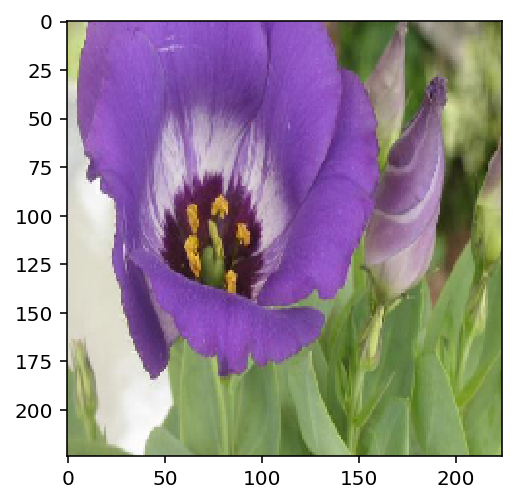

In [11]:
def imshow(image, ax=None, title=None):
    if ax is None:
        fig, ax = plt.subplots()
    
    # PyTorch tensors assume the color channel is the first dimension
    # but matplotlib assumes is the third dimension
    image = image.transpose((1, 2, 0))
    
    # Undo preprocessing
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean
    
    # Image needs to be clipped between 0 and 1 or it looks like noise when displayed
    image = np.clip(image, 0, 1)
    
    ax.imshow(image)
    
    return ax
imshow(test_image)

## Class Prediction

Once you can get images in the correct format, it's time to write a function for making predictions with your model. A common practice is to predict the top 5 or so (usually called top-$K$) most probable classes. You'll want to calculate the class probabilities then find the $K$ largest values.

To get the top $K$ largest values in a tensor use [`x.topk(k)`](http://pytorch.org/docs/master/torch.html#torch.topk). This method returns both the highest `k` probabilities and the indices of those probabilities corresponding to the classes. You need to convert from these indices to the actual class labels using `class_to_idx` which hopefully you added to the model or from an `ImageFolder` you used to load the data ([see here](#Save-the-checkpoint)). Make sure to invert the dictionary so you get a mapping from index to class as well.

Again, this method should take a path to an image and a model checkpoint, then return the probabilities and classes.

```python
probs, classes = predict(image_path, model)
print(probs)
print(classes)
> [ 0.01558163  0.01541934  0.01452626  0.01443549  0.01407339]
> ['70', '3', '45', '62', '55']
```

In [12]:
def predict(image_path, model, topk=5):
    ''' Predict the class (or classes) of an image using a trained deep learning model.
    '''
    
    # TODO: Implement the code to predict the class from an image file
    model.eval()
    img = process_image(image_path)
    img = torch.from_numpy(np.array(img)).float()
    img = img.to('cpu')
    img.unsqueeze_(0)
    output = model.forward(img)
    probs, classes = torch.exp(output).topk(topk)
    probs = probs.detach().numpy()[0]
    classes = classes.numpy()[0]

    
    return probs, classes
class_dict = {}
for i in model.class_to_idx:
    class_dict[model.class_to_idx[i]] = i
    
probs, classes = predict(image_file, model)
print(probs)
print(classes)
updated_classes = []
for i in classes: 
    updated_classes.append(class_dict[i])

[ 0.01384595  0.01350849  0.01334721  0.01324927  0.01311201]
[11 91 16 96  8]


## Sanity Checking

Now that you can use a trained model for predictions, check to make sure it makes sense. Even if the testing accuracy is high, it's always good to check that there aren't obvious bugs. Use `matplotlib` to plot the probabilities for the top 5 classes as a bar graph, along with the input image. It should look like this:

<img src='assets/inference_example.png' width=300px>

You can convert from the class integer encoding to actual flower names with the `cat_to_name.json` file (should have been loaded earlier in the notebook). To show a PyTorch tensor as an image, use the `imshow` function defined above.

Figure(640x480)


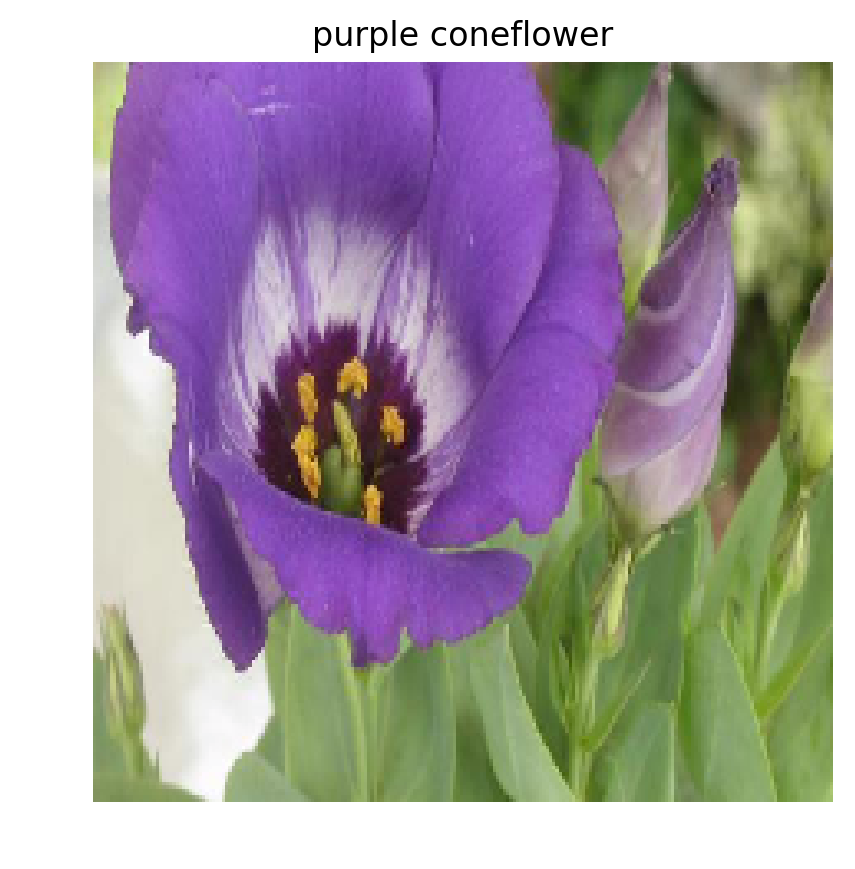

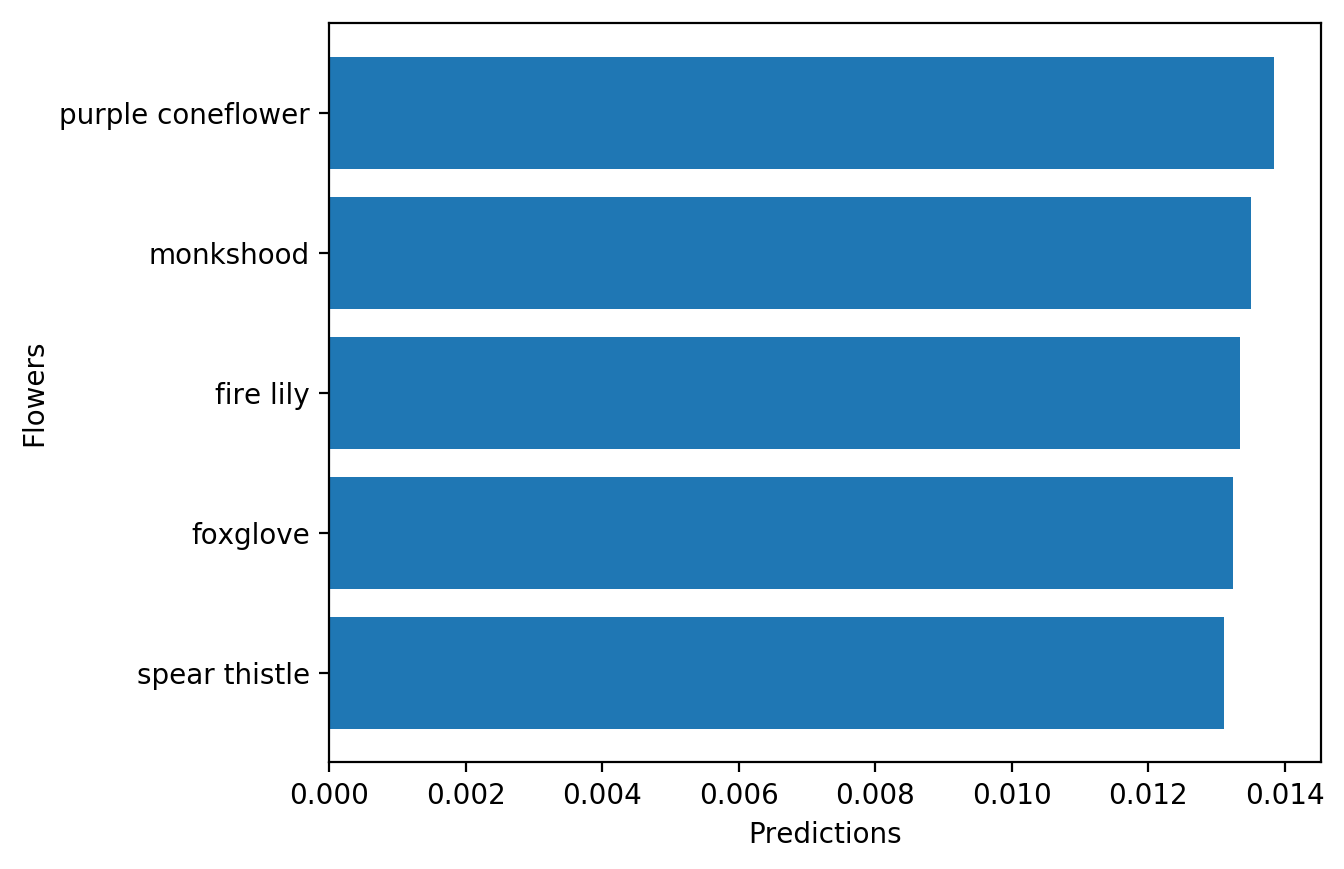

In [33]:
# TODO: Display an image along with the top 5 classes
class_names = []
for i in updated_classes:
    class_names.append(cat_to_name[str(i)])

# Took the imshow function used above and created a new function to show image without axises and with a title
def top_img(image, ax=None, title=None):
    ''' Display the image of the flower with the highest probability
    '''
    fig_image, ax_image = plt.subplots()
    
    # PyTorch tensors assume the color channel is the first dimension
    # but matplotlib assumes is the third dimension
    image = image.transpose((1, 2, 0))
    
    # Undo preprocessing
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean
    
    # Image needs to be clipped between 0 and 1 or it looks like noise when displayed
    image = np.clip(image, 0, 1)
    plt.title(class_names[0])
    plt.axis('off')
    
    ax_image.imshow(image)


# Turn prob, classes into Pandas dataframe
data = {'Classes' : pd.Series(class_names), 'Probabilites' : pd.Series(probs)}
probability_chart = pd.DataFrame(data)


# Create bar chart
def create_bar_chart(chart, classes):
    ''' Display a bar chart that shows the probabilites of the top 5 flowers classes predicted.
    '''
    base_color = sb.color_palette()[0]

    fig, ax = plt.subplots()

    # Create y position variable to use the length of the class names. 
    y_pos = np.arange(len(class_names))
    # Create the bars to use the probabiliites from the variable probs. 
    ax.barh(y_pos, probs, color=base_color)
    ax.set_ylabel('Flowers')
    ax.set_yticks(y_pos)
    ax.set_yticklabels(class_names)
    # Invert the y axis so the hightest probability is the bar at the top. 
    ax.invert_yaxis()
    ax.set_xlabel('Predictions')

    plt.show()

top_img(test_image)
create_bar_chart(probability_chart, class_names)